# Dataset Exploration -  walker2d

In [124]:
from d3rlpy.datasets import get_minari
import gymnasium as gym

In [125]:
dataset, _ = get_minari("mujoco/walker2d/medium-v0")
env = gym.make("Walker2d-v5", render_mode="human")

2025-07-30 10:30.10 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('float32')], shape=[(6,)]) observation_signature=Signature(dtype=[dtype('float64')], shape=[(17,)]) reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)])
2025-07-30 10:30.10 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.CONTINUOUS: 1>
2025-07-30 10:30.10 [info     ] Action size has been automatically determined. action_size=6


## Data Exploration

In [126]:
print("Total transitions:", dataset.transition_count)
print("Number of episodes:", len(dataset.episodes))

Total transitions: 998627
Number of episodes: 1044


In [127]:
first_episode = dataset.episodes[0]
print("Length of first episode:", len(first_episode.rewards))

Length of first episode: 1000


## Reward Distribution

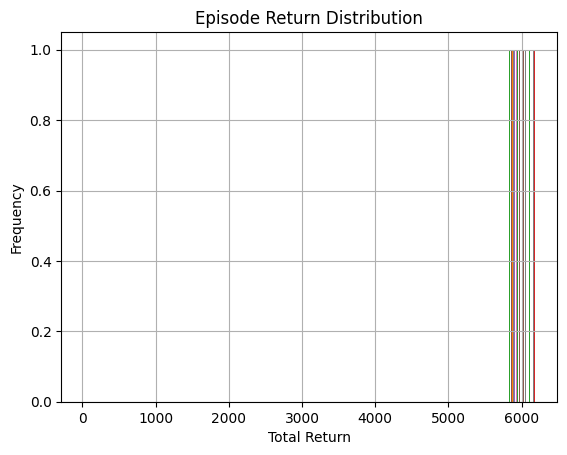

In [128]:
import matplotlib.pyplot as plt

episode_rewards = [sum(ep.rewards) for ep in dataset.episodes]

plt.hist(episode_rewards, bins=30)
plt.title("Episode Return Distribution")
plt.xlabel("Total Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [129]:
ep = dataset.episodes[i]
print("Observations:", ep.observations.shape)
print("Actions:", ep.actions.shape)
print("Rewards:", ep.rewards.shape)

Observations: (1000, 17)
Actions: (1000, 6)
Rewards: (1000, 1)


## State Action Relationship

In [130]:
import numpy as np

observations = []
actions = []
rewards = []
next_observations = []
dones = []

for ep in dataset.episodes:
    observations.append(ep.observations[:-1])
    actions.append(ep.actions[:-1])
    rewards.append(ep.rewards[:-1])
    next_observations.append(ep.observations[1:])
    dones.append(np.array([ep.terminated]))

# Flatten all episodes
observations = np.concatenate(observations, axis=0)
actions = np.concatenate(actions, axis=0)
rewards = np.concatenate(rewards, axis=0)
next_observations = np.concatenate(next_observations, axis=0)
dones = np.concatenate(dones, axis=0)

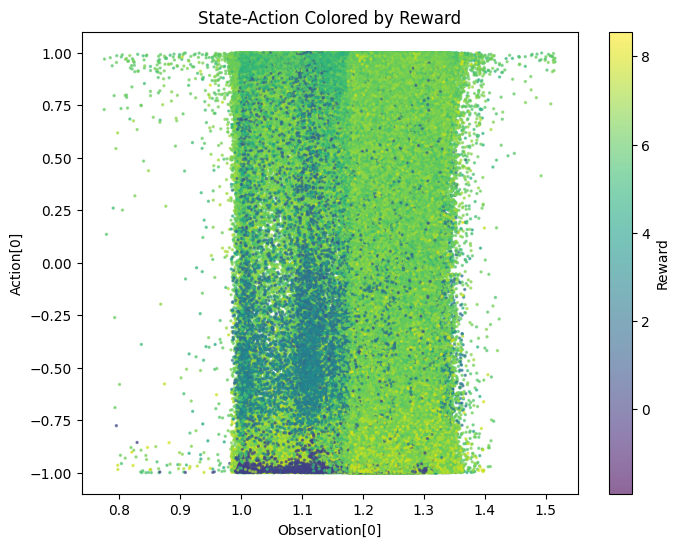

In [131]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(observations[:, 0], actions[:, 0], c=rewards, cmap="viridis", alpha=0.6, s=2)
plt.xlabel("Observation[0]")
plt.ylabel("Action[0]")
plt.title("State-Action Colored by Reward")
plt.colorbar(label="Reward")
plt.show()

## Trajectory Over Time 

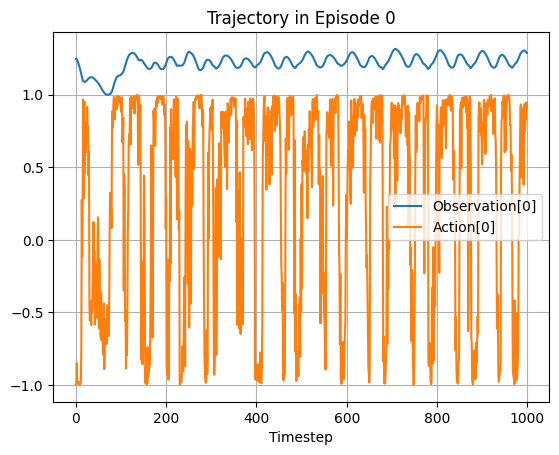

In [132]:
ep = dataset.episodes[0]

plt.plot(ep.observations[:, 0], label="Observation[0]")
plt.plot(ep.actions[:, 0], label="Action[0]")
plt.title("Trajectory in Episode 0")
plt.xlabel("Timestep")
plt.legend()
plt.grid(True)
plt.show()

## Animated Rollout 

In [133]:
env = gym.make("Walker2d-v4", render_mode="rgb_array")

obs, _ = env.reset()
frames = []

done = False
while not done:
    action = env.action_space.sample()
    obs, reward, terminated, truncated, _ = env.step(action)
    frame = env.render()
    frames.append(frame)
    done = terminated or truncated

import imageio

imageio.mimsave("rollout.gif", frames, fps=20)



## Action or Observation Stats Plot

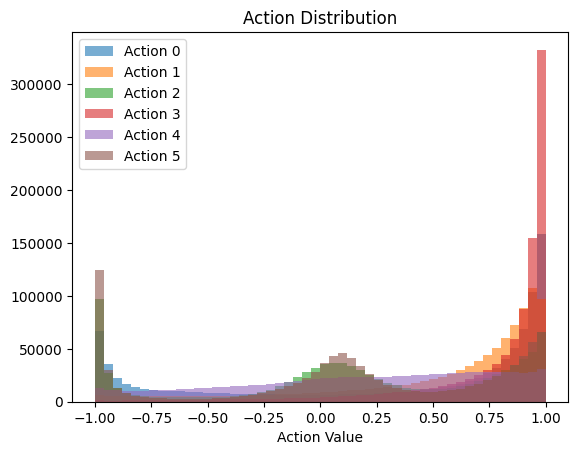

In [134]:
import numpy as np

actions = np.vstack([ep.actions for ep in dataset.episodes])

plt.figure()
for i in range(actions.shape[1]):
    plt.hist(actions[:, i], bins=50, alpha=0.6, label=f'Action {i}')
plt.title("Action Distribution")
plt.xlabel("Action Value")
plt.legend()
plt.show()

## Observations

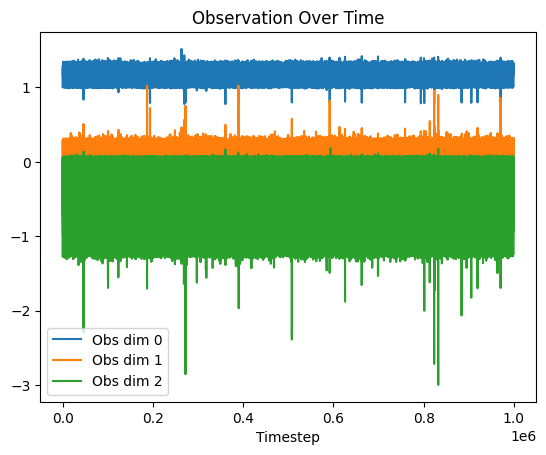

In [135]:
obs = np.vstack([ep.observations for ep in dataset.episodes])

plt.figure()
for i in range(min(3, obs.shape[1])):  # plot first 3 dimensions
    plt.plot(obs[:, i], label=f'Obs dim {i}')
plt.title("Observation Over Time")
plt.xlabel("Timestep")
plt.legend()
plt.show()

In [136]:
print("Average episode return:", np.mean(episode_rewards))
print("Max return:", np.max(episode_rewards))
print("Min return:", np.min(episode_rewards))
print("Average episode length:", np.mean([len(ep.rewards) for ep in dataset.episodes]))

Average episode return: 5701.642653750668
Max return: 6198.89836798548
Min return: 0.2035283034852593
Average episode length: 957.4837164750958


# Conservative Q-Learning - Training

In [137]:
from d3rlpy.algos import CQLConfig, BCConfig

In [138]:
cql = CQLConfig().create(device="cpu")

In [139]:
bc = BCConfig().create(device="cpu")

In [ ]:
epochs, metrics = cql.fit(
        dataset,
        n_steps=50000,
        n_steps_per_epoch=10000,
        save_interval=1,
        experiment_name='cql_walker2d',
    )

In [60]:
bc.fit(
        dataset,
        n_steps=10000,
        n_steps_per_epoch=2000,
        experiment_name='bc_walker2d',
    )

2025-07-29 09:19.18 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(17,)]), action_signature=Signature(dtype=[dtype('float32')], shape=[(6,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.CONTINUOUS: 1>, action_size=6)
2025-07-29 09:19.18 [debug    ] Building models...            
2025-07-29 09:19.18 [debug    ] Models have been built.       
2025-07-29 09:19.18 [info     ] Directory is created at d3rlpy_logs/bc_walker2d_20250729091918
2025-07-29 09:19.18 [info     ] Parameters                     params={'observation_shape': [17], 'action_size': 6, 'config': {'type': 'bc', 'params': {'batch_size': 100, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'compile_graph': False, 'learning_rate': 0.001, 'policy_type': 'deterministic', 'optim

Epoch 1/5:   0%|          | 0/2000 [00:00<?, ?it/s]

2025-07-29 09:19.23 [info     ] bc_walker2d_20250729091918: epoch=1 step=2000 epoch=1 metrics={'time_sample_batch': 0.0006998900175094605, 'time_algorithm_update': 0.001390528678894043, 'loss': 0.3397427153289318, 'time_step': 0.002109147071838379} step=2000
2025-07-29 09:19.23 [info     ] Model parameters are saved to d3rlpy_logs/bc_walker2d_20250729091918/model_2000.d3


Epoch 2/5:   0%|          | 0/2000 [00:00<?, ?it/s]

2025-07-29 09:19.27 [info     ] bc_walker2d_20250729091918: epoch=2 step=4000 epoch=2 metrics={'time_sample_batch': 0.0006672500371932983, 'time_algorithm_update': 0.0013780616521835327, 'loss': 0.3372597140669823, 'time_step': 0.0020630817413330076} step=4000
2025-07-29 09:19.27 [info     ] Model parameters are saved to d3rlpy_logs/bc_walker2d_20250729091918/model_4000.d3


Epoch 3/5:   0%|          | 0/2000 [00:00<?, ?it/s]

2025-07-29 09:19.31 [info     ] bc_walker2d_20250729091918: epoch=3 step=6000 epoch=3 metrics={'time_sample_batch': 0.0006708685159683228, 'time_algorithm_update': 0.0014080806970596313, 'loss': 0.3374778874516487, 'time_step': 0.002098371505737305} step=6000
2025-07-29 09:19.31 [info     ] Model parameters are saved to d3rlpy_logs/bc_walker2d_20250729091918/model_6000.d3


Epoch 4/5:   0%|          | 0/2000 [00:00<?, ?it/s]

2025-07-29 09:19.35 [info     ] bc_walker2d_20250729091918: epoch=4 step=8000 epoch=4 metrics={'time_sample_batch': 0.0006722981929779052, 'time_algorithm_update': 0.0013824304342269897, 'loss': 0.33758215913176537, 'time_step': 0.0020740506649017335} step=8000
2025-07-29 09:19.35 [info     ] Model parameters are saved to d3rlpy_logs/bc_walker2d_20250729091918/model_8000.d3


Epoch 5/5:   0%|          | 0/2000 [00:00<?, ?it/s]

2025-07-29 09:19.40 [info     ] bc_walker2d_20250729091918: epoch=5 step=10000 epoch=5 metrics={'time_sample_batch': 0.000680909276008606, 'time_algorithm_update': 0.0015250529050827026, 'loss': 0.33798795591294767, 'time_step': 0.002225932002067566} step=10000
2025-07-29 09:19.40 [info     ] Model parameters are saved to d3rlpy_logs/bc_walker2d_20250729091918/model_10000.d3


[(1,
  {'time_sample_batch': 0.0006998900175094605,
   'time_algorithm_update': 0.001390528678894043,
   'loss': 0.3397427153289318,
   'time_step': 0.002109147071838379}),
 (2,
  {'time_sample_batch': 0.0006672500371932983,
   'time_algorithm_update': 0.0013780616521835327,
   'loss': 0.3372597140669823,
   'time_step': 0.0020630817413330076}),
 (3,
  {'time_sample_batch': 0.0006708685159683228,
   'time_algorithm_update': 0.0014080806970596313,
   'loss': 0.3374778874516487,
   'time_step': 0.002098371505737305}),
 (4,
  {'time_sample_batch': 0.0006722981929779052,
   'time_algorithm_update': 0.0013824304342269897,
   'loss': 0.33758215913176537,
   'time_step': 0.0020740506649017335}),
 (5,
  {'time_sample_batch': 0.000680909276008606,
   'time_algorithm_update': 0.0015250529050827026,
   'loss': 0.33798795591294767,
   'time_step': 0.002225932002067566})]